In [4]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.models.train_model import *
from src.visualization.vis_data import *
from src.features.landuse import *

import seaborn as sns
output_notebook()
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [203]:
# start building dataset from scratch only perform this when new data files are added 
dataset = Dataset('Hanoi')
dataset.build_all_data(build_fire=False, build_holiday=False)

Averaging data from 3 stations


In [2]:
dataset = Dataset('Hanoi')
dataset.load_()

# Pollution

Index(['PM2.5'], dtype='object')


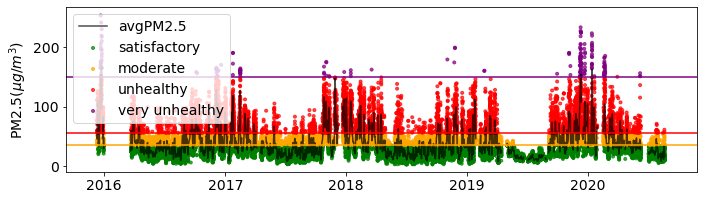

In [8]:
# plot the raw data
plot_all_pollutions(dataset.poll_df, city_name=dataset.city_name)

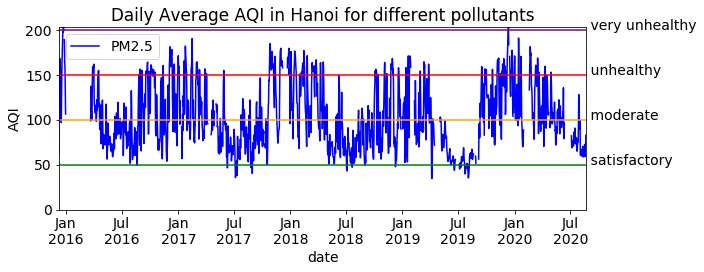

In [15]:
plot_polls_aqi(dataset.poll_df.copy(), dataset.roll_dict, dataset.city_name, filename=dataset.report_folder + 'all_pol_aqi.png' )

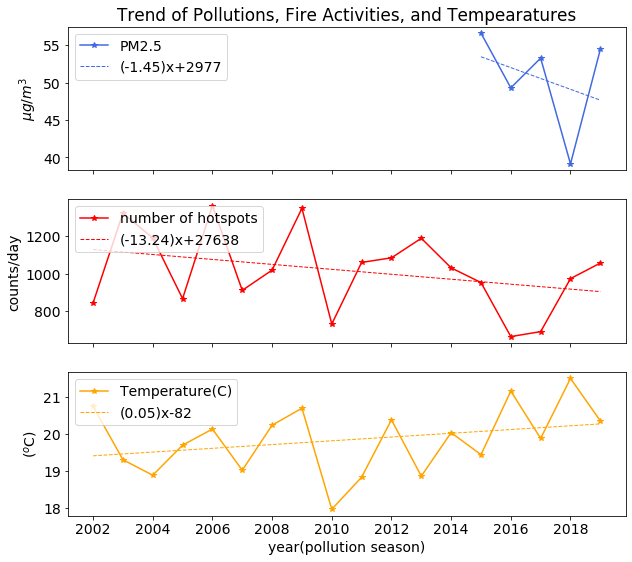

In [19]:
ax, year_avg = plot_yearly_ln(dataset, filename=dataset.report_folder + 'compare_ln_trends.png')

aqi 100 in  08-22 to 06-08
aqi 150 in  10-08 to 04-16


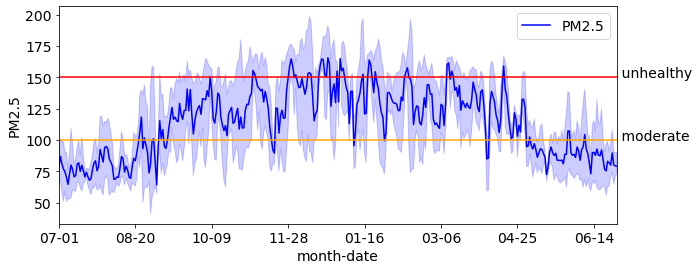

In [20]:
plot_season_aqi(dataset.poll_df.copy(), dataset.roll_dict, 'PM2.5', filename=dataset.report_folder + 'seasonal_pattern_PM25.png')

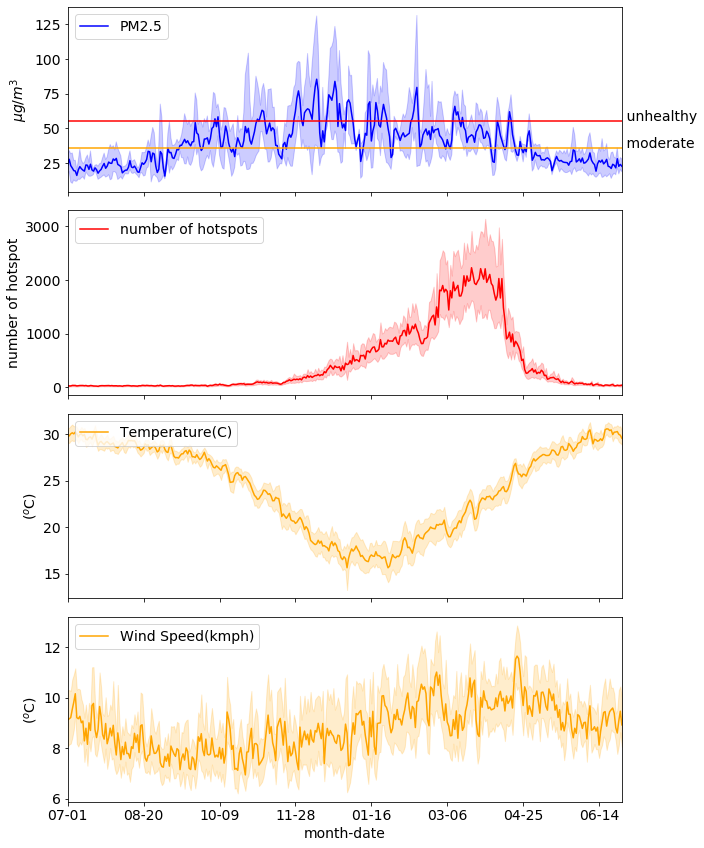

In [21]:
compare_seson_avg(dataset, agg='mean', filename=dataset.report_folder + 'fire_PM25_season.png')

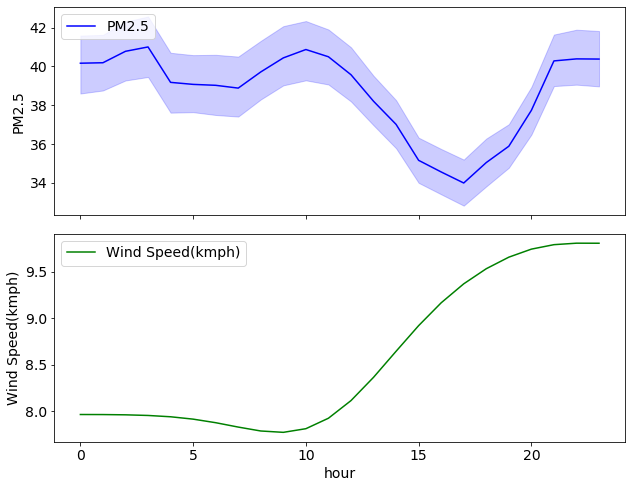

In [20]:
_, ax = plt.subplots(2, 1, figsize=(9, 7), sharex=True)
plot_hour_avg(dataset.poll_df.copy(), 'PM2.5', ax[0],  color='blue')
 
df = df.groupby('time_of_day').mean().rolling(2, min_periods=0,center=True).mean()
ax[1].plot(df['Wind_Speed(kmph)'], color='green', label='Wind_Speed(kmph)')
ax[1].set_ylabel('Wind_Speed(kmph)')
ax[1].set_xlabel('hour')
ax[1].legend(loc='upper left')
plt.tight_layout()

# Chemical Fingerprint

In [40]:
# load daily average pollution data
aqcn = pd.read_csv(glob('../data/aqcn_data/hanoi*.txt')[0],na_values=' ')
aqcn.columns = ['datetime','PM2.5','PM10', 'O3', 'NO2', 'SO2', 'CO']
aqcn['datetime'] = pd.to_datetime(aqcn['datetime'])

In [56]:
# extract all data from Vietnamese EPA 
dfs = glob('../data/vn_epa/*.csv')
hanoi_df = []
for df in dfs:
    df = pd.read_csv(df, na_values='-')
    # keep only hanoi data
    df = df[df['city'] == 'Hanoi']
    df['datetime'] = pd.to_datetime(df['datetime'])
    hanoi_df.append(df)
    
hanoi_df = pd.concat(hanoi_df, ignore_index=True)
# drop duplicates data
hanoi_df = hanoi_df.drop_duplicates()
hanoi_df = hanoi_df.drop(['VN_AQI', 'city','station'], axis=1)
hanoi_df = hanoi_df.sort_values('datetime')
# taking average of all the station in hanoi
hanoi_df = hanoi_df.groupby('datetime', as_index=False).mean().round()

In [57]:
hanoi_df = pd.concat([hanoi_df, aqcn]).drop_duplicates('datetime').sort_values('datetime')

In [58]:
hanoi_df = hanoi_df.set_index('datetime')

In [60]:
# calculate the average 
sum_df = hanoi_df.mean()

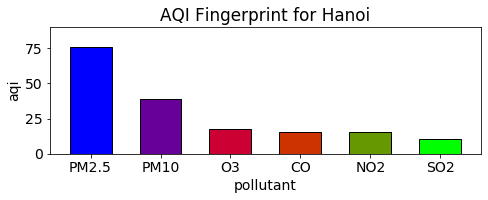

In [63]:
plot_chem_print(sum_df, dataset.city_name, filename=dataset.report_folder + 'fingerprint.png')

# Map 

Fire map and power plants from https://endcoal.org/tracker/

In [130]:
dataset.city_info

x = merc_x(dataset.city_info['Longitude'])
y = merc_y(dataset.city_info['Latitude'])
#stepx = 2E5

stepx = 1E6
stepy = stepx

In [146]:
# select fire data 
fire = dataset.fire
i = 0
month_list = ['2019-03','2019-04']
month = month_list[i]
color = 'red'
fire1 = fire.loc[month:month_list[i+1]]

month_list = ['2018-12','2019-01']
month = month_list[i]
fire2 = fire.loc[month:month_list[i+1]]

In [147]:
# range bounds supplied in web mercator coordinates
p = figure(x_range=(x-1*stepx,x+1*stepx), y_range=(y-stepy*0.3, y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = dataset.city_name)
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))

# add city center
p.scatter(x,y,color='red',line_color='black',size=10, legend_label=dataset.city_name)

# plot hotspots at the begining and end of winter season

p.scatter(fire1['long_km']*1000,fire1['lat_km']*1000,color='red',size=1, alpha=0.5,legend_label='fire in Mar 2019')

p.scatter(fire2['long_km']*1000,fire2['lat_km']*1000,color='blue',size=1, alpha=0.5, legend_label='fire in Dec 2018')

#add circles
labels = ['0-120km','120-400km','400-700km','700-1200km']

rs = [120, 400, 700, 1200]
rs.reverse()
colors = get_color(color_length=len(labels),cmap=cm.jet)
for i, (r, label, color) in enumerate(zip(rs, labels, colors)):
    if i ==3 or i ==2:
        alpha=0.4
    else:
        alpha=0.2
        
    xy = get_circle(x,y,r=r*1E3)
    p.patch(xy[0,:],xy[1,:],alpha=alpha,line_width=2,line_color='black',color=color, legend_label=label)
    
p.legend.location = "bottom_right"

show(p)

In [123]:
# list of power plants hear Hanoi
plants = [[20.4809977, 106.5604517, 'coal']]

# Landuse

In [ ]:
dataset = Dataset('Hanoi')
dataset.load_()
label_landuse_fire('../data/hanoi/' + 'fire_m.csv')
fire = pd.read_csv('../data/hanoi/fire_m_label.csv')
fire = add_countries(fire, city_xy_m=[dataset.city_info['long_m'], dataset.city_info['lat_m']], filename='../data/jakarta/fire_m_label.csv')


0it [00:00, ?it/s]

C:/Users/Benny/Documents/Fern/aqi_thailand2/data/hanoi/fire_m_label.csv



1it [00:30, 30.80s/it]


2it [00:57, 29.66s/it]


3it [01:24, 28.69s/it]


4it [01:49, 27.69s/it]


5it [02:14, 26.96s/it]


6it [02:40, 26.59s/it]


7it [03:06, 26.26s/it]


8it [03:31, 26.04s/it]


9it [03:57, 25.92s/it]


10it [04:22, 25.87s/it]


11it [04:48, 25.87s/it]


12it [05:14, 25.84s/it]


13it [05:40, 25.80s/it]


14it [06:05, 25.75s/it]


15it [06:31, 25.74s/it]


16it [06:57, 25.64s/it]


17it [07:22, 25.55s/it]


18it [07:47, 25.45s/it]


19it [08:12, 25.36s/it]


20it [08:40, 26.11s/it]


21it [09:05, 25.85s/it]


22it [09:31, 25.67s/it]


23it [09:56, 25.58s/it]


24it [10:22, 25.68s/it]


25it [10:47, 25.64s/it]


26it [11:13, 25.55s/it]


27it [11:38, 25.50s/it]


28it [12:04, 25.51s/it]


29it [12:31, 26.18s/it]


30it [12:59, 26.44s/it]


31it [13:25, 26.34s/it]


32it [13:50, 26.17s/it]


33it [14:16, 26.07s/it]


34it [14:43, 26.14s/it]


35it [15:25, 31.11s/it]


36it [16:06, 34.09s/it]


37it [16:35, 32.57s/it]


38it [17:01, 30.49s/it]


39it [17:27, 29.12s/it]


40it [17:53, 28.30s/it]


41it [18:19, 27.61s/it]


42it [18:46, 27.20s/it]


43it [19:11, 26.80s/it]


44it [19:37, 26.49s/it]


45it [20:03, 26.31s/it]


46it [20:42, 29.99s/it]


47it [21:07, 28.74s/it]


48it [21:33, 27.86s/it]


49it [21:59, 27.19s/it]


50it [22:24, 26.69s/it]


51it [22:50, 26.34s/it]


52it [23:16, 26.14s/it]


53it [23:41, 26.03s/it]


54it [24:07, 25.98s/it]


55it [24:33, 25.97s/it]


56it [24:59, 25.91s/it]


57it [25:25, 25.86s/it]


58it [25:51, 25.85s/it]


59it [26:16, 25.88s/it]


60it [26:53, 28.93s/it]


61it [27:18, 28.00s/it]


62it [27:45, 27.45s/it]


63it [28:10, 26.98s/it]


64it [28:37, 26.74s/it]


65it [29:02, 26.45s/it]


66it [29:28, 26.23s/it]


67it [29:57, 26.96s/it]


68it [30:22, 26.60s/it]


69it [30:49, 26.69s/it]


70it [31:15, 26.45s/it]


71it [31:41, 26.24s/it]


72it [32:07, 26.11s/it]


73it [32:33, 26.18s/it]


74it [33:00, 26.24s/it]


75it [33:27, 26.47s/it]


76it [33:55, 26.93s/it]


77it [34:23, 27.33s/it]


78it [34:52, 27.77s/it]


79it [35:18, 27.30s/it]


80it [35:44, 27.03s/it]


81it [36:11, 26.94s/it]


82it [36:37, 26.68s/it]


83it [37:03, 26.40s/it]


84it [37:31, 27.05s/it]


85it [37:57, 26.70s/it]


86it [38:23, 26.43s/it]


87it [38:49, 26.38s/it]


88it [39:15, 26.21s/it]


89it [39:41, 26.09s/it]


90it [40:07, 26.01s/it]


91it [40:33, 26.00s/it]


92it [40:59, 26.00s/it]


93it [41:25, 25.99s/it]


94it [41:51, 25.99s/it]


95it [42:17, 25.94s/it]


96it [42:43, 26.06s/it]


97it [43:09, 26.02s/it]


98it [43:35, 26.02s/it]


99it [44:01, 26.01s/it]


100it [44:27, 26.02s/it]


101it [44:53, 26.04s/it]


102it [45:19, 26.13s/it]


103it [45:45, 26.14s/it]


104it [46:12, 26.12s/it]


105it [46:38, 26.19s/it]


106it [47:04, 26.19s/it]


107it [47:30, 26.12s/it]


108it [47:56, 26.04s/it]


109it [48:25, 26.88s/it]


110it [48:51, 26.81s/it]


111it [49:17, 26.49s/it]


112it [49:53, 29.26s/it]


113it [50:19, 28.26s/it]


114it [50:45, 27.61s/it]


115it [51:11, 27.13s/it]


116it [51:37, 26.74s/it]


117it [52:03, 26.51s/it]


118it [52:29, 26.58s/it]


119it [52:59, 27.35s/it]


120it [53:27, 27.53s/it]


121it [53:54, 27.39s/it]


122it [54:20, 27.16s/it]


123it [54:47, 27.13s/it]


124it [55:14, 27.00s/it]


125it [55:41, 26.88s/it]


126it [56:07, 26.84s/it]


127it [56:34, 26.88s/it]


128it [57:04, 27.86s/it]


129it [57:31, 27.51s/it]


130it [57:58, 27.38s/it]


131it [58:25, 27.07s/it]


132it [58:51, 26.94s/it]


133it [59:17, 26.72s/it]


134it [59:44, 26.55s/it]


135it [1:00:10, 26.41s/it]


136it [1:00:36, 26.27s/it]


137it [1:01:02, 26.25s/it]


138it [1:01:28, 26.30s/it]


139it [1:01:55, 26.36s/it]


140it [1:02:21, 26.31s/it]


141it [1:02:47, 26.37s/it]


142it [1:03:14, 26.34s/it]


143it [1:03:40, 26.32s/it]


144it [1:04:06, 26.34s/it]


145it [1:04:33, 26.31s/it]


146it [1:04:59, 26.25s/it]


147it [1:05:27, 26.85s/it]


148it [1:05:53, 26.69s/it]


149it [1:06:19, 26.56s/it]


150it [1:06:46, 26.53s/it]


151it [1:07:12, 26.39s/it]


152it [1:07:38, 26.37s/it]


153it [1:08:06, 26.82s/it]


154it [1:08:33, 26.88s/it]


155it [1:09:01, 27.02s/it]


156it [1:09:28, 27.17s/it]


157it [1:09:56, 27.28s/it]


158it [1:10:24, 27.51s/it]


159it [1:10:51, 27.48s/it]


160it [1:11:18, 27.37s/it]


161it [1:11:47, 27.84s/it]


162it [1:12:17, 28.43s/it]


163it [1:12:45, 28.29s/it]


164it [1:13:12, 28.02s/it]


165it [1:13:40, 27.79s/it]


166it [1:14:07, 27.80s/it]


167it [1:14:35, 27.67s/it]


168it [1:15:03, 27.76s/it]


169it [1:15:34, 28.82s/it]


170it [1:16:03, 28.89s/it]


171it [1:16:31, 28.63s/it]


172it [1:17:02, 29.20s/it]


173it [1:17:34, 30.29s/it]


174it [1:18:45, 42.34s/it]


175it [1:19:12, 37.88s/it]


176it [1:19:41, 34.97s/it]


177it [1:20:06, 32.02s/it]


178it [1:20:31, 29.99s/it]


179it [1:20:58, 29.05s/it]


180it [1:21:24, 28.34s/it]


181it [1:21:51, 27.81s/it]


182it [1:22:18, 27.45s/it]


183it [1:22:44, 27.22s/it]


184it [1:23:11, 27.02s/it]


185it [1:23:38, 26.98s/it]


186it [1:24:05, 26.94s/it]


187it [1:24:32, 27.09s/it]


188it [1:25:01, 27.73s/it]


189it [1:25:28, 27.41s/it]


190it [1:25:55, 27.20s/it]


191it [1:26:21, 27.01s/it]


192it [1:26:48, 26.93s/it]


193it [1:27:15, 26.87s/it]


194it [1:27:42, 26.94s/it]


195it [1:28:09, 26.91s/it]


196it [1:28:35, 26.89s/it]


197it [1:29:02, 26.77s/it]


198it [1:29:28, 26.61s/it]


199it [1:29:55, 26.59s/it]


200it [1:30:21, 26.51s/it]


201it [1:30:47, 26.45s/it]


202it [1:31:14, 26.44s/it]


203it [1:31:40, 26.43s/it]


204it [1:32:06, 26.30s/it]


205it [1:32:33, 26.39s/it]


206it [1:33:00, 26.62s/it]


207it [1:33:39, 30.46s/it]


208it [1:34:07, 29.60s/it]


209it [1:34:49, 33.23s/it]


210it [1:35:26, 34.43s/it]


211it [1:35:52, 32.07s/it]


212it [1:36:20, 30.68s/it]


213it [1:36:59, 33.16s/it]


214it [1:37:27, 31.62s/it]


215it [1:37:53, 29.84s/it]


216it [1:38:21, 29.41s/it]


217it [1:38:51, 29.55s/it]


218it [1:39:18, 28.72s/it]


219it [1:39:44, 28.06s/it]


220it [1:40:11, 27.75s/it]


221it [1:41:01, 34.41s/it]


222it [1:41:29, 32.33s/it]


223it [1:41:55, 30.62s/it]


224it [1:42:21, 29.13s/it]


225it [1:42:48, 28.44s/it]


226it [1:43:13, 27.60s/it]


227it [1:43:39, 27.04s/it]


228it [1:44:05, 26.69s/it]


229it [1:44:31, 26.49s/it]


230it [1:45:00, 27.28s/it]


231it [1:45:26, 26.75s/it]


232it [1:45:51, 26.41s/it]


233it [1:46:17, 26.15s/it]


234it [1:46:43, 26.08s/it]


235it [1:47:08, 25.88s/it]


236it [1:47:34, 25.86s/it]


237it [1:48:00, 25.99s/it]


238it [1:48:26, 25.95s/it]


239it [1:48:53, 26.09s/it]


240it [1:49:20, 26.51s/it]


241it [1:49:47, 26.61s/it]


242it [1:50:13, 26.51s/it]


243it [1:50:42, 27.11s/it]


244it [1:51:08, 26.94s/it]


245it [1:51:34, 26.68s/it]


246it [1:52:00, 26.38s/it]


247it [1:52:26, 26.36s/it]


248it [1:52:53, 26.45s/it]


249it [1:53:19, 26.36s/it]


250it [1:53:45, 26.22s/it]


251it [1:54:10, 25.98s/it]


252it [1:54:37, 26.21s/it]


253it [1:55:08, 27.49s/it]


254it [1:55:45, 30.42s/it]


255it [1:56:12, 29.40s/it]


256it [1:56:38, 28.49s/it]


257it [1:57:05, 28.03s/it]


258it [1:57:32, 27.67s/it]


259it [1:57:59, 27.44s/it]


260it [1:58:25, 27.12s/it]


261it [1:58:52, 27.12s/it]


262it [1:59:20, 27.18s/it]


263it [1:59:46, 26.97s/it]


264it [2:00:13, 26.83s/it]


265it [2:00:39, 26.60s/it]


266it [2:01:05, 26.52s/it]


267it [2:01:31, 26.35s/it]


268it [2:01:58, 26.43s/it]


269it [2:02:24, 26.45s/it]


270it [2:02:51, 26.43s/it]


271it [2:03:17, 26.48s/it]


272it [2:03:43, 26.32s/it]


273it [2:04:09, 26.28s/it]


274it [2:04:38, 27.03s/it]


275it [2:05:34, 35.67s/it]


276it [2:06:00, 32.75s/it]


277it [2:06:26, 30.89s/it]


278it [2:06:53, 29.47s/it]


279it [2:07:19, 28.49s/it]


280it [2:07:45, 27.74s/it]


281it [2:08:11, 27.36s/it]


282it [2:08:37, 27.04s/it]


283it [2:09:03, 26.73s/it]


284it [2:09:30, 26.65s/it]


285it [2:09:56, 26.52s/it]


286it [2:10:23, 26.54s/it]


287it [2:10:49, 26.50s/it]


288it [2:11:16, 26.47s/it]


289it [2:11:42, 26.32s/it]


290it [2:12:08, 26.33s/it]


291it [2:12:34, 26.34s/it]


292it [2:13:01, 26.35s/it]


293it [2:13:29, 27.09s/it]


294it [2:13:56, 26.83s/it]


295it [2:14:22, 26.59s/it]


296it [2:14:48, 26.55s/it]


297it [2:15:14, 26.39s/it]


298it [2:15:41, 26.65s/it]


299it [2:16:08, 26.52s/it]


300it [2:16:35, 26.64s/it]


301it [2:17:01, 26.50s/it]


302it [2:17:27, 26.53s/it]


303it [2:17:54, 26.46s/it]


304it [2:18:20, 26.43s/it]


305it [2:18:47, 26.52s/it]


306it [2:19:13, 26.48s/it]


307it [2:19:43, 27.35s/it]


308it [2:20:22, 30.98s/it]


309it [2:20:50, 30.00s/it]


310it [2:21:18, 29.45s/it]


311it [2:21:45, 28.87s/it]


312it [2:22:13, 28.36s/it]


313it [2:22:40, 28.16s/it]


314it [2:23:07, 27.88s/it]


315it [2:23:35, 27.86s/it]


316it [2:24:05, 28.35s/it]


317it [2:24:35, 28.84s/it]


318it [2:25:05, 29.15s/it]


319it [2:25:32, 28.74s/it]


320it [2:26:11, 31.76s/it]

# ML Model

In [174]:
dataset = Dataset('Hanoi')
dataset.load_()
dataset.feature_no_fire(fill_missing=True, cat_hour=True,group_hour=1)
fire_cols, *args = dataset.merge_fire()

data no fire has shape (35617, 37)
use default fire feature


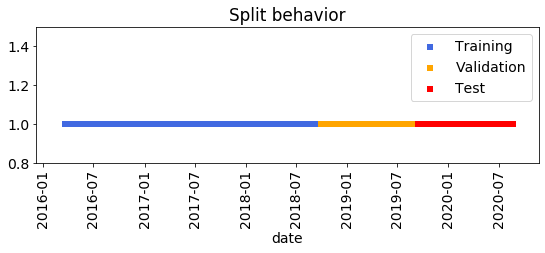

In [177]:
dataset.split_data(split_ratio=[0.6, 0.2, 0.2])
display_time_split(dataset.split_list)

In [180]:
model_meta = load_meta(dataset.model_folder + 'model_meta.json')

In [188]:
poll_meta = {'rolling_win': 1,
 'cat_hour': True,
 'fill_missing': True,
 'group_hour': 2}

In [189]:
split_lists = [[0.40, 0.3, 0.3], [0.45, 0.25, 0.3], [0.7, 0.3]]

In [190]:
poll_meta['split_lists'] = split_lists

In [192]:
model_meta['PM2.5'] = poll_meta

In [193]:
save_meta(dataset.model_folder + 'model_meta.json', model_meta)

data no fire has shape (34927, 21)
use default fire feature
=================optimize 1: find the best RF model=================
{'n_estimators': 160, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False} 0.019438650192425924
optimize 1 score {'val_r2_score': 0.20330309079236597, 'val_mean_squared_error': 435.078776612921, 'val_mean_absolute_error': 16.515898261179096}
=================optimize 2: remove unncessary columns=================
old cols length 24
drop wind_CALM
drop wind_N
drop day_of_week
drop fire_120_400
drop fire_700_1200
use columns ['Temperature(C)', 'Humidity(%)', 'Wind_Speed(kmph)', 'wind_E', 'wind_S', 'wind_W', 'is_rain', 'is_holiday', 'is_weekend', 'time_of_day_[0, 3)', 'time_of_day_[3, 6)', 'time_of_day_[6, 9)', 'time_of_day_[9, 12)', 'time_of_day_[12, 15)', 'time_of_day_[15, 18)', 'time_of_day_[18, 21)', 'time_of_day_[21, 24)', 'fire_0_120', 'fire_400_700']
score after dropping columns {'r2_score': 0.2391

val score before refit {'val_r2_score': 0.42678686540658695, 'val_mean_squared_error': 305.49849332364994, 'val_mean_absolute_error': 12.744743170755786}
test score before refit {'test_r2_score': 0.40859428585184754, 'test_mean_squared_error': 456.41491608435524, 'test_mean_absolute_error': 14.494332847929392}
final score for test set {'test_r2_score': 0.41373469449065614, 'test_mean_squared_error': 452.4478269585755, 'test_mean_absolute_error': 14.276865401510767}


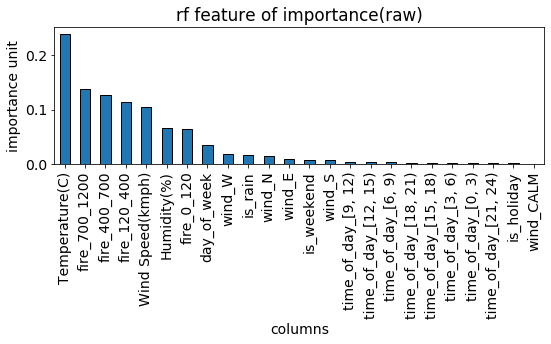

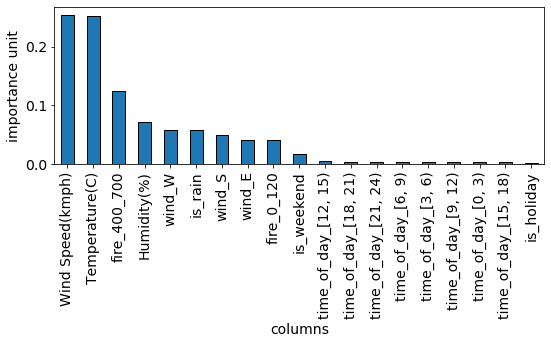

In [205]:
dataset, model, poll_meta = train_city_s1(city= 'Hanoi', pollutant='PM2.5')

In [209]:
dataset, model, fire_cols, zone_list, feat_imp, roll_win = load_model(city='Hanoi', pollutant='PM2.5', split_list=[0.7, 0.3])

data no fire has shape (35460, 21)
raw model performance {'test_r2_score': 0.414208489900155, 'test_mean_squared_error': 450.01122112292995, 'test_mean_absolute_error': 14.20457498191814}
daily avg training error {'avg_trn_r2_score': 0.9462374841578516, 'avg_trn_mean_squared_error': 24.580453158344366, 'avg_trn_mean_absolute_error': 3.6473295088750137}
daily avg test error {'avg_test_r2_score': 0.5647975629974505, 'avg_test_mean_squared_error': 235.03172881732388, 'avg_test_mean_absolute_error': 11.309632327167138}


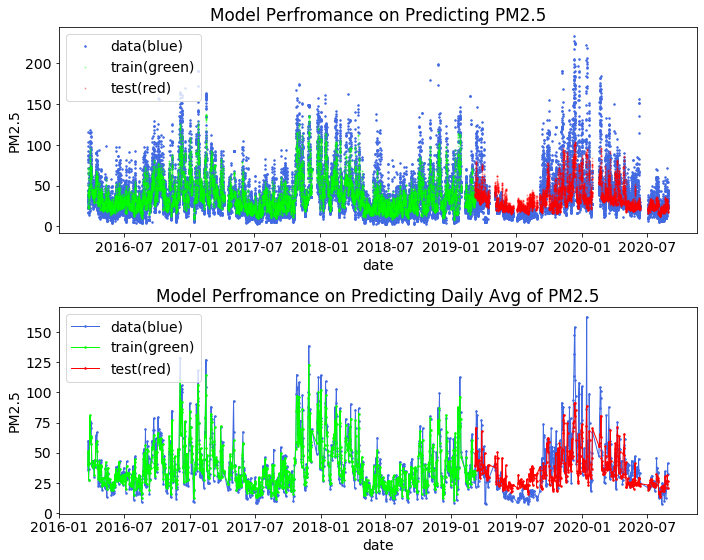

In [210]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=dataset, model=model, split_list=[0.7, 0.3], xlim=[], to_save=True)